<a href="https://www.kaggle.com/code/aisuko/text-to-image-with-diffusion-pipeline?scriptVersionId=164208321" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview

We'll take a closesr look at the components - the model and scheduler in Huggingface diffusers that make up the DiffusionPipline and learn how to use these components to generate an image of a cat.

In [1]:
%%capture
!pip install diffusers==0.26.3
# ImportError: cannot import name 'CpuOffload' from 'accelerate.hooks'
!pip install transformers==4.38.1
!pip install accelerate==0.27.2

In [2]:
import os
import torch

os.environ['MODEL_NAME']='google/ddpm-cat-256'

if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'

print(torch_device)

cuda


In [3]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Loading the model

Most models take a noise sample, and at each timrstep it predicts the `noise residual`(other models learn to predict the previous sample directly or thr velocity or v-prediction), the difference between a less noisy image and the input image. You can mix and match models to create other diffusion systems.

For example, `UNet2DModel` a basic unconditional image generation model with a checkpoint trained on cat images:

In [4]:
from diffusers import UNet2DModel

model = UNet2DModel.from_pretrained(os.getenv('MODEL_NAME'))
model.to(torch_device)
print(model.config)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

FrozenDict([('sample_size', 256), ('in_channels', 3), ('out_channels', 3), ('center_input_sample', False), ('time_embedding_type', 'positional'), ('freq_shift', 1), ('flip_sin_to_cos', False), ('down_block_types', ['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D']), ('up_block_types', ['UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D']), ('block_out_channels', [128, 128, 256, 256, 512, 512]), ('layers_per_block', 2), ('mid_block_scale_factor', 1), ('downsample_padding', 0), ('downsample_type', 'conv'), ('upsample_type', 'conv'), ('dropout', 0.0), ('act_fn', 'silu'), ('attention_head_dim', None), ('norm_num_groups', 32), ('attn_norm_num_groups', None), ('norm_eps', 1e-06), ('resnet_time_scale_shift', 'default'), ('add_attention', True), ('class_embed_type', None), ('num_class_embeds', None), ('num_train_timesteps', None), ('_use_default_values', ['num_train_timesteps', 'upsample_type', 'num_class_embeds', 'attn_n

The model configuration is a frozen dictionary, which means those parameters can't be changed after the model is created. This is intentional and ensures that the parameters used to define the model architecture at the start remain the same, while other parameters can still be adjusted during inference.

Some of the most important parameters are:
* `sample_size`: the height and width dimension of the input sample.
* `in_channels`: the number of input channels of the input sample.
* `down_block_types` and `up_block_types`: the type of down and unsampling blocks used to create the UNet architecture.
* `block_out_channels`: the number of output channels of the downsampling blocks; also used in reverse order for the number of input channels of the upsampling blocks.
* `layers_per_block`: the number of ResNet blocks present in each UNet block.


# Create image shapre with random Gaussian noise

To use the model for inference, `create the image shape with random Gaussian noise`. It should have `a batch axis because the model` can `receive multiple random noises`, a channel axis corresponding to the number of input channels, and a sample size axis for the height and width of the image:


In [5]:
torch.manual_seed(0)

noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size).to(torch_device)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

# Inference

For inference, pass the noisy image to the model and a `timestep`. The `timestep` indicates how noisy the input image is, with more noise at the beginning and less at the end. This helps the model determine its position in the diffusion process, whether it is closer to the start or the end. Use the sample method to get the model output:

In [6]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

# Schedulers

Schedulers manage going from a noisy sample to a less noisy sample given the model output, in this case, it i `noisy_residual`.

In [7]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(os.getenv('MODEL_NAME'))
print(scheduler)

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



## Configuration

Unlike a model, a scheduler does not have trainable weights and is parameter-free, and some of the most important parameters are:
* `num_train_timesteps`: the length of the denoising process or in other words, the number of timesteps required to process random Gaussian noise into a data sample.
* `beta_schedule`: the type of noise schedule to use for inference and training.
* `beta_start` and `beta_end`: the start and end noise values for the noise schedule.

## Pedicting less noisy images

To predict a slightly less noisy image, pass the following to the scheduler's step() method:
* model output
* timestep
* current sample

The less_noisy_sample can be passed to the next timestep where it will get even less noisier:

```python
less_noisy_sample = scheduler.step(model_output=noisy_residual, timestep=2, sample=noisy_sample).prev_sample
less_noisy_sample.shape
```

# Display the denoised image

In [8]:
noisy_sample = noisy_sample.to(torch_device)
sample=noisy_sample

# Creating denoising loop

It predicts the residual of the less noisy sample, and computes the less noisy sample with the scheduler.

 10%|▉         | 98/1000 [00:06<01:00, 14.99it/s]

'Image at step 100'

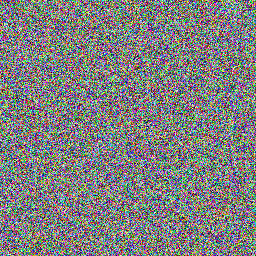

 20%|█▉        | 199/1000 [00:13<00:53, 14.99it/s]

'Image at step 200'

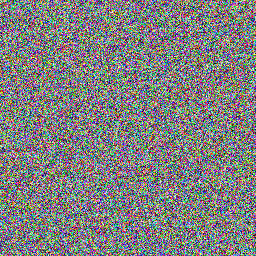

 30%|██▉       | 299/1000 [00:20<00:46, 14.98it/s]

'Image at step 300'

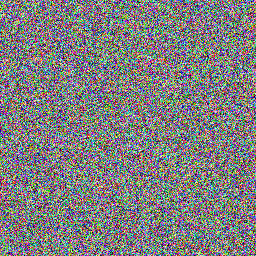

 40%|███▉      | 399/1000 [00:26<00:40, 14.98it/s]

'Image at step 400'

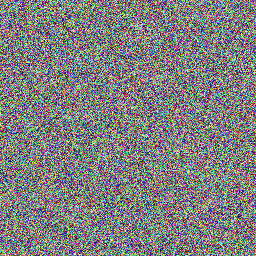

 50%|████▉     | 499/1000 [00:33<00:33, 14.99it/s]

'Image at step 500'

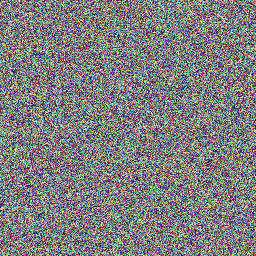

 60%|█████▉    | 599/1000 [00:40<00:26, 14.98it/s]

'Image at step 600'

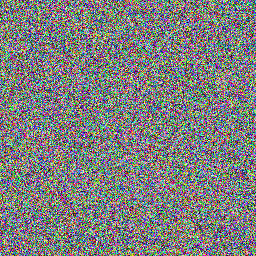

 70%|██████▉   | 699/1000 [00:46<00:20, 14.98it/s]

'Image at step 700'

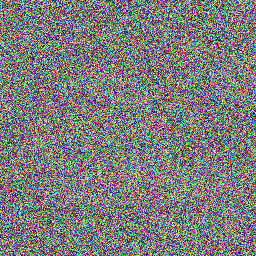

 80%|███████▉  | 799/1000 [00:53<00:13, 14.97it/s]

'Image at step 800'

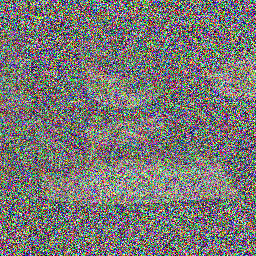

 90%|████████▉ | 899/1000 [01:00<00:06, 14.95it/s]

'Image at step 900'

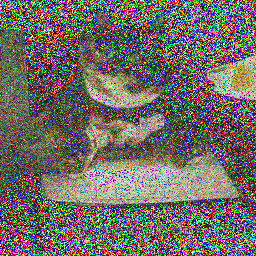

100%|█████████▉| 999/1000 [01:06<00:00, 14.97it/s]

'Image at step 1000'

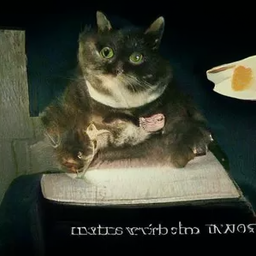

100%|██████████| 1000/1000 [01:07<00:00, 14.91it/s]


In [9]:
import tqdm
import PIL.Image
import numpy as np

def display_sample(sample, i):
    # change the tensor to cpu and rearranges the dimensions of the tensor
    image_processed = sample.cpu().permute(0,2,3,1)
    # scales the pixel values of the tensor to the range [0, 255]
    image_processed = (image_processed +1.0) * 127.5
    # change the type from float to uint8 to get more efficient with less memory
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)


for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # predict noise residual
    with torch.no_grad():
        residual=model(sample=sample, timestep=t).sample
    # compute less noisy image and sed set x_t -> x_t-1
    sample = scheduler.step(model_output=residual, timestep=t, sample=sample).prev_sample
    # optionally look at imge
    if (i+1) % 100 == 0:
        display_sample(sample, i+1)

## Conclusion

I have been tried `Euler` scheduler to get more high quality picture, but it cause issue on mps. It is hard to debug.